Using device: cuda
Training samples: 50000
Test samples: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.6817627].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7983952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.2477236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8378451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

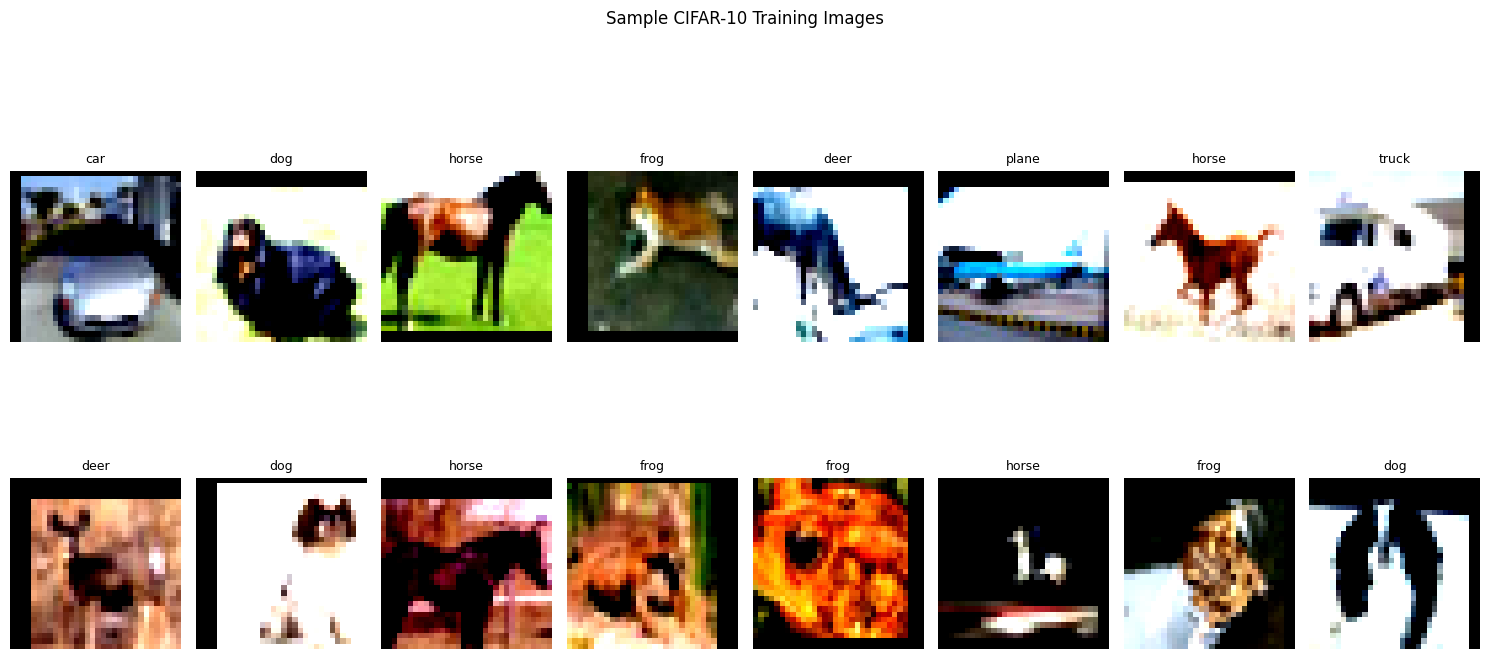

In [1]:
# Vision Transformer vs CNN on CIFAR-10
## Complete PyTorch Implementation with Step-by-Step Visualizations


## ================= STEP 1: Setup and Data Loading =================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f'Training samples: {len(trainset)}')
print(f'Test samples: {len(testset)}')

# Visualize sample training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(2, 8, figsize=(15, 8))
for idx in range(16):
    ax = axes[idx // 8, idx % 8]
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[idx]], fontsize=9)
    ax.axis('off')
plt.suptitle('Sample CIFAR-10 Training Images')
plt.tight_layout()
plt.show()

In [2]:
## ============================ STEP 2: Vision Transformer (ViT) Architecture ==============================

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, num_classes=10, embed_dim=256, depth=6, num_heads=8):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 3, embed_dim)
        n_patches = self.patch_embed.n_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        
        self.blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        x = self.head(x[:, 0])
        return x


# Create ViT model
vit_model = VisionTransformer().to(device)
print(f'ViT Parameters: {sum(p.numel() for p in vit_model.parameters()):,}')

ViT Parameters: 4,771,082


In [3]:
## ============================ STEP 3: CNN Architecture =================================

class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create CNN model
cnn_model = CNNClassifier().to(device)
print(f'CNN Parameters: {sum(p.numel() for p in cnn_model.parameters()):,}')

CNN Parameters: 3,249,994


In [4]:
## ============================= STEP 4: Training Functions ====================================

def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs, model_name):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        epoch_val_loss = val_running_loss / len(testloader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        print(f'{model_name} Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
    
    return train_losses, train_accs, val_losses, val_accs

In [5]:
## ============================= Evaluating Functions ====================================

def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1
    
    accuracy = 100. * correct / total
    class_accuracies = [100. * class_correct[i] / class_total[i] for i in range(10)]
    
    return accuracy, class_accuracies

In [6]:
## ========================== STEP 5: Train Both Models =================================

num_epochs = 200

# Train ViT
print("\n" + "="*50)
print("Training Vision Transformer")
print("="*50)
criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.AdamW(vit_model.parameters(), lr=0.0001)
vit_train_losses, vit_train_accs, vit_val_losses, vit_val_accs = train_model(vit_model, trainloader, testloader, criterion_vit, optimizer_vit, num_epochs, "ViT")

# Train CNN
print("\n" + "="*50)
print("Training CNN")
print("="*50)
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.0001)
cnn_train_losses, cnn_train_accs, cnn_val_losses, cnn_val_accs = train_model(cnn_model, trainloader, testloader, criterion_cnn, optimizer_cnn, num_epochs, "CNN")


Training Vision Transformer
ViT Epoch 1/200 - Train Loss: 1.7555, Train Acc: 34.99% | Val Loss: 1.5503, Val Acc: 43.70%
ViT Epoch 2/200 - Train Loss: 1.4048, Train Acc: 48.82% | Val Loss: 1.3503, Val Acc: 51.90%
ViT Epoch 3/200 - Train Loss: 1.2479, Train Acc: 54.95% | Val Loss: 1.2564, Val Acc: 55.47%
ViT Epoch 4/200 - Train Loss: 1.1539, Train Acc: 58.43% | Val Loss: 1.1872, Val Acc: 57.70%
ViT Epoch 5/200 - Train Loss: 1.0783, Train Acc: 61.01% | Val Loss: 1.0556, Val Acc: 62.19%
ViT Epoch 6/200 - Train Loss: 1.0067, Train Acc: 63.81% | Val Loss: 1.0243, Val Acc: 63.45%
ViT Epoch 7/200 - Train Loss: 0.9544, Train Acc: 65.87% | Val Loss: 0.9420, Val Acc: 66.16%
ViT Epoch 8/200 - Train Loss: 0.9129, Train Acc: 67.50% | Val Loss: 0.9485, Val Acc: 65.78%
ViT Epoch 9/200 - Train Loss: 0.8732, Train Acc: 68.95% | Val Loss: 0.8825, Val Acc: 68.46%
ViT Epoch 10/200 - Train Loss: 0.8360, Train Acc: 70.19% | Val Loss: 0.8401, Val Acc: 70.23%
ViT Epoch 11/200 - Train Loss: 0.8037, Train Acc: 

In [7]:
## ============================= STEP 6: Evaluate and Compare ====================================

# Evaluate both models
vit_acc, vit_class_accs = evaluate_model(vit_model, testloader)
cnn_acc, cnn_class_accs = evaluate_model(cnn_model, testloader)

print(f"\nViT Test Accuracy: {vit_acc:.2f}%")
print(f"CNN Test Accuracy: {cnn_acc:.2f}%")


ViT Test Accuracy: 79.18%
CNN Test Accuracy: 89.77%


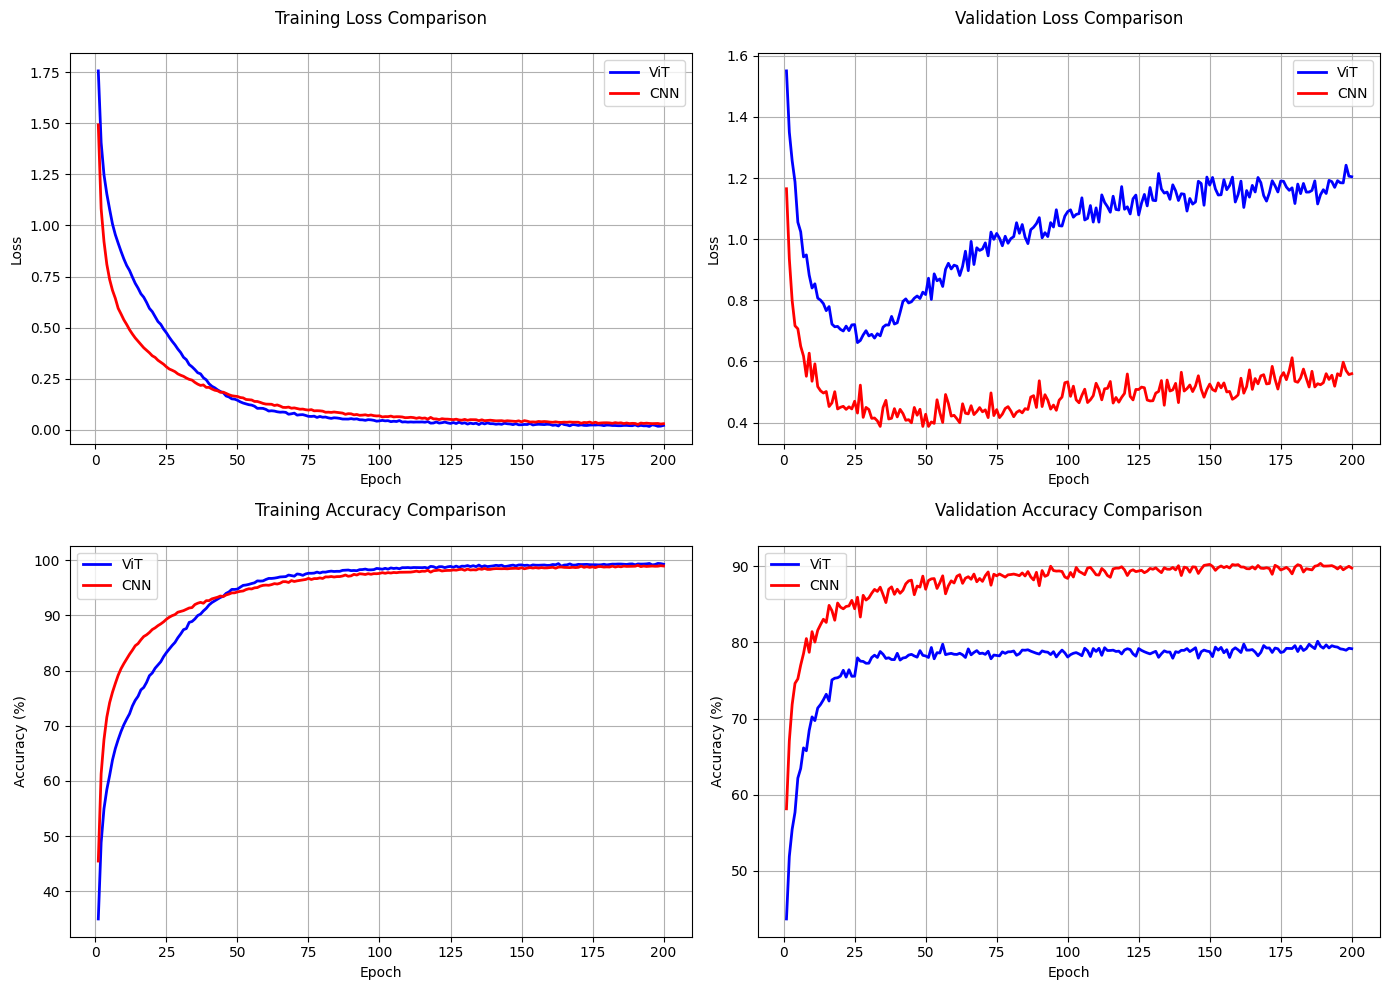

In [8]:
### ==================== Visualization 1: Training Loss and Accuracy ===============================

plt.figure(figsize=(14, 10))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs+1), vit_train_losses, 'b-', label='ViT', linewidth=2)
plt.plot(range(1, num_epochs+1), cnn_train_losses, 'r-', label='CNN', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison\n')
plt.legend()
plt.grid(True)

# Validation Loss
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs+1), vit_val_losses, 'b-', label='ViT', linewidth=2)
plt.plot(range(1, num_epochs+1), cnn_val_losses, 'r-', label='CNN', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison\n')
plt.legend()
plt.grid(True)

# Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs+1), vit_train_accs, 'b-', label='ViT', linewidth=2)
plt.plot(range(1, num_epochs+1), cnn_train_accs, 'r-', label='CNN', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison\n')
plt.legend()
plt.grid(True)

# Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs+1), vit_val_accs, 'b-', label='ViT', linewidth=2)
plt.plot(range(1, num_epochs+1), cnn_val_accs, 'r-', label='CNN', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Comparison\n')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

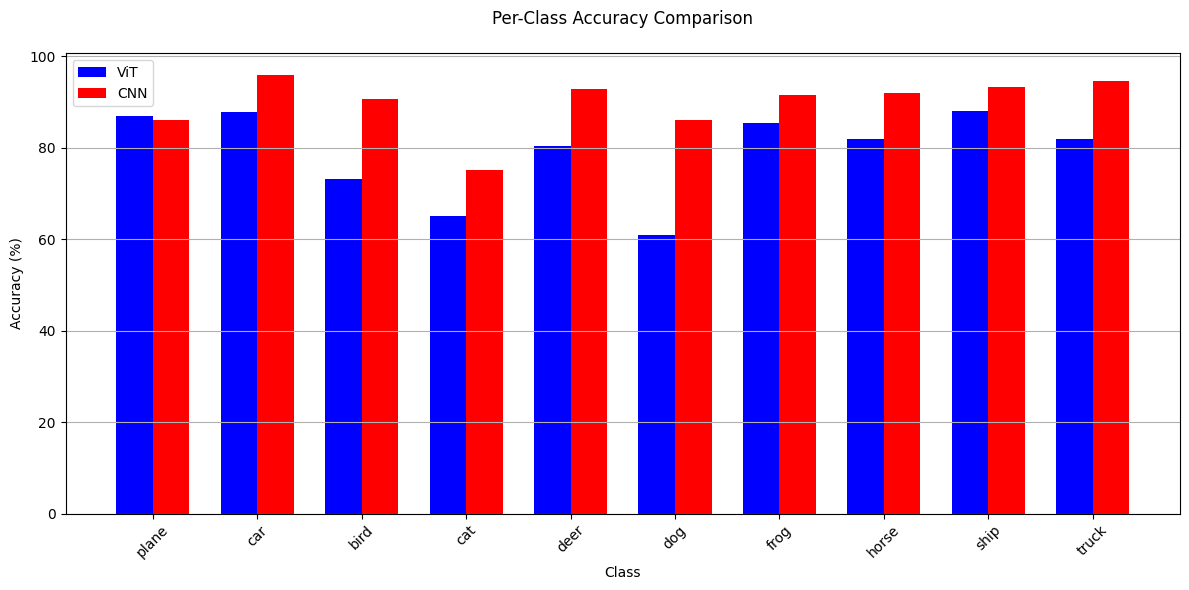

In [9]:
### ========================== Visualization 2: Per-Class Accuracy ==============================

plt.figure(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, vit_class_accs, width, label='ViT', color='blue')
plt.bar(x + width/2, cnn_class_accs, width, label='CNN', color='red')

plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy Comparison\n')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.704840

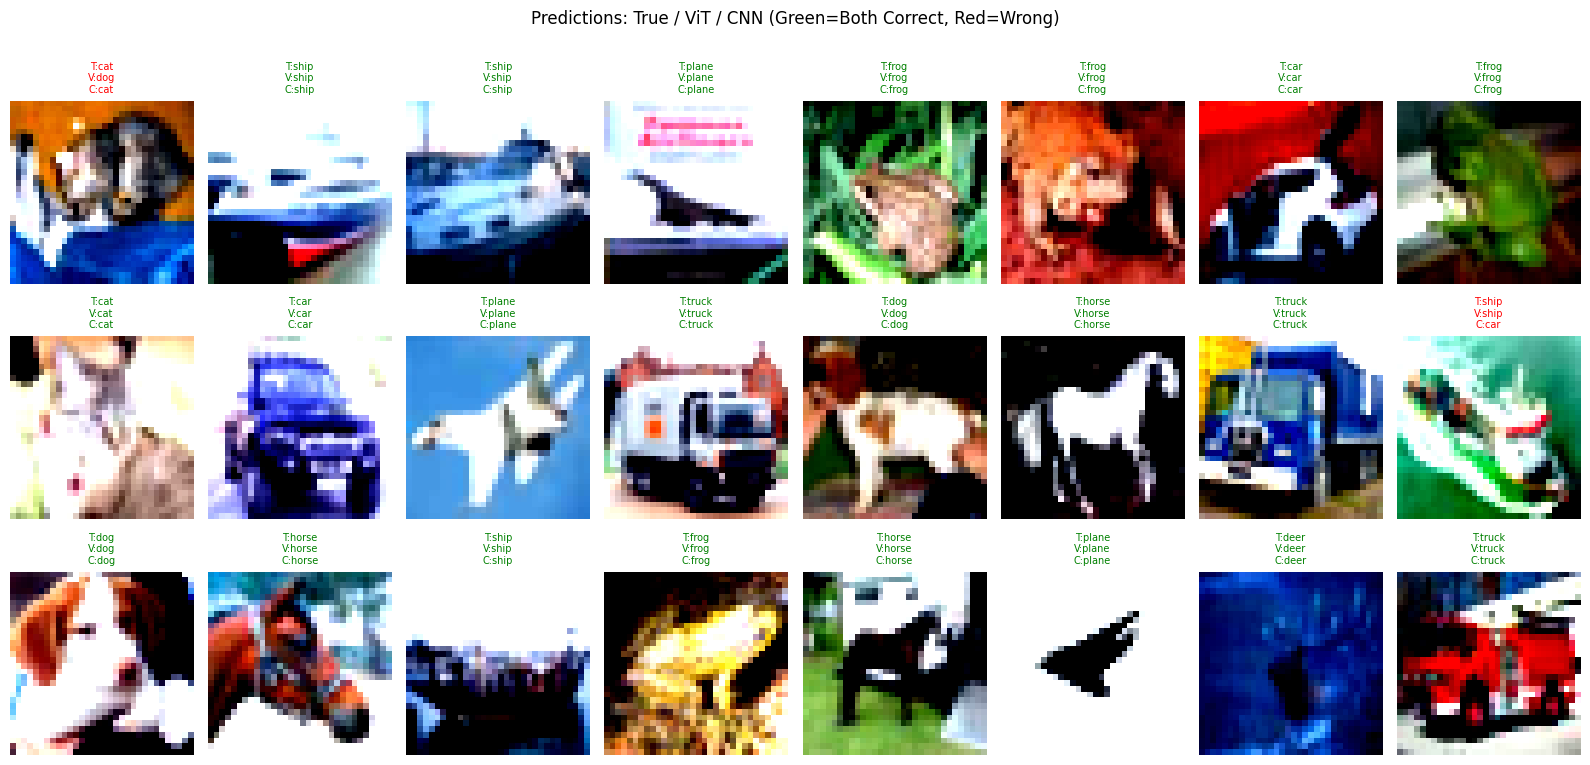

In [10]:
### ============================= Visualization 3: Sample Predictions ==================================

# Get test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)

# Get predictions
vit_model.eval()
cnn_model.eval()
with torch.no_grad():
    vit_outputs = vit_model(images)
    cnn_outputs = cnn_model(images)

_, vit_preds = vit_outputs.max(1)
_, cnn_preds = cnn_outputs.max(1)

# Display predictions
fig, axes = plt.subplots(3, 8, figsize=(16, 8))
for idx in range(24):
    ax = axes[idx // 8, idx % 8]
    img = images[idx].cpu() / 2 + 0.5
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    
    true = classes[labels[idx]]
    vit_p = classes[vit_preds[idx]]
    cnn_p = classes[cnn_preds[idx]]
    
    color = 'green' if (vit_preds[idx] == labels[idx] and cnn_preds[idx] == labels[idx]) else 'red'
    ax.set_title(f'T:{true}\nV:{vit_p}\nC:{cnn_p}', fontsize=7, color=color)
    ax.axis('off')

plt.suptitle('Predictions: True / ViT / CNN (Green=Both Correct, Red=Wrong)\n')
plt.tight_layout()
plt.show()